<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/3_Pre_%26_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mf
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split


for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 3.0 Feature scaling

Implemento il min max scaling delle features. 

Riferimento: https://towardsdatascience.com/data-normalization-with-pandas-and-scikit-learn-7c1cc6ed6475

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv'):
  correlation_data = min_max_scaling(correlation_data)
  correlation_data.to_csv(r'./corr_data.csv')

if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  correlation_data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/corr_data.csv')

Riferimento `save_model` e `load_model`: https://stackoverflow.com/questions/56107259/how-to-save-a-trained-model-by-scikit-learn

Riferimento confusion matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


### Dataset merging

Funzione che ritorna la lista delle colonne significative. 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # serve per ignorare i FutureWarning

Rimpiazzo i missing values in categorical data con unknown. 

Unisco i dataset numerici e categorici nel dataframe data. 

Riferimento fillna: https://jamesrledoux.com/code/imputation

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv'):
  col_to_drop = col_not_sign(categorical_data, cat_sign_col)
  categorical_data = categorical_data.drop(col_to_drop, axis=1)
  categorical_data = categorical_data.fillna('unknown')
  data = pd.merge(correlation_data, categorical_data, left_on='TransactionID', right_on='TransactionID', how='left')
  del correlation_data, categorical_data, numerical_data
  data.to_csv(r'./data.csv')

data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

## 3.2 One hot encoding

One hot encoding delle features categoriche. Serve per lo smote e easy ensemble. 

Bisogna farlo prima dello split del dataset poichè rischio di perdere delle colonne. 

In [ ]:
data = pd.get_dummies(data)

In [ ]:
cols = mf.get_col(data)

Seleziono i dati appartenenti ai primi 60 giorni. 

Se ne seleziono di più, l'easy ensemble non va. 

In [ ]:
data = mf.select_days(data, 60)

Splitto il dataset in train, validation e test set. 

In [ ]:
X_train, X_val, y_train, y_val = mf.split(data, test_size = 0.2)
del data
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

## 3.3 Undersampling: Easy Ensemble

L'easy ensemble tramite un metodo unsupervised divide il dataset in diversi dataset undersampled. 

Documentazione easy ensemble: http://glemaitre.github.io/imbalanced-learn/generated/imblearn.ensemble.EasyEnsemble.html#imblearn.ensemble.EasyEnsemble

Esempio applicazio ee: http://glemaitre.github.io/imbalanced-learn/auto_examples/ensemble/plot_easy_ensemble.html?highlight=easy%20ensemble

In [ ]:
X_trainres, y_trainres = mf.easy_ensemble(5, X_train, y_train)

In [ ]:
X_trainres_df = pd.DataFrame(data = X_trainres[0], columns = cols)
del X_trainres

## 3.4 XGBoost

Provo a trainare un random forest con cross validation sui vari dataset splittati attraverso easy ensemble. 

ROC curve: https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_roc_curve_visualization_api.html#sphx-glr-auto-examples-miscellaneous-plot-roc-curve-visualization-api-py

XGBoost: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

gpu_hist method: https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-hist-and-gpu-hist-tree-method

In [ ]:
X_val = X_val.values

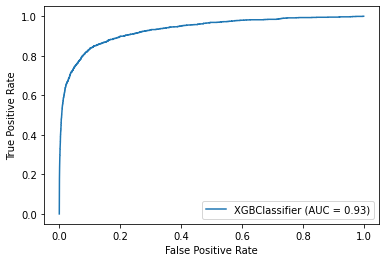

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import plot_roc_curve
from xgboost import XGBClassifier

clf = XGBClassifier(n_estimators = 4000, max_depth = 20, alpha=0.5, objective='binary:logistic', learning_rate = 1, tree_method='gpu_hist') #learning_rate=0.05)
# clf = RandomForestClassifier(n_estimators = 4000, max_depth=10, random_state=0, oob_score = True)
# clf.fit(X_train, y_train)
clf.fit(X_trainres[0], y_trainres[0])
plot_roc_curve(clf, X_val, y_val)
plt.show()

AP max = 0.64

AP: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

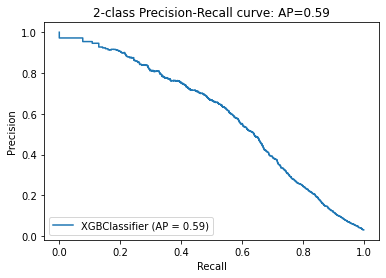

In [ ]:
mf.ap_metric(clf, X_val, y_val)

Text(0, 0.5, 'Feature Importance Score')

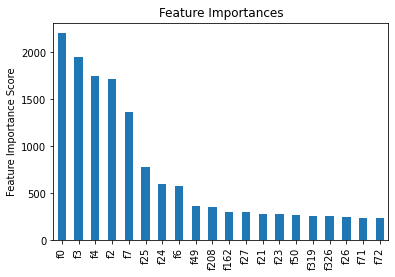

In [ ]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp[:20].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### ROC AUC curve

Riferimento: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

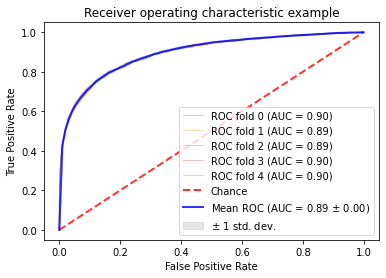

In [ ]:
mf.roc_auc_subset(XGBClassifier(), X_trainres, y_trainres, X_val, y_val)

In [ ]:
catboost_cols = X_trainres_df.columns[(X_trainres_df.dtypes == int) | (X_trainres_df.dtypes == float)]

Riferimento apply: https://stackoverflow.com/questions/17950374/converting-a-column-within-pandas-dataframe-from-int-to-string

Catboost bad object errore: https://github.com/catboost/catboost/issues/482

In [ ]:
for col in X_trainres_df:
  if col in catboost_cols:
    X_trainres_df[col] = X_trainres_df[col].apply(str)